In [ ]:
import os
import sys
import numpy as np
from typing import Union, Optional

from torch_geometric.data import InMemoryDataset, Data
from torch import load, save, tensor
import torch 

from ase.io import read
from ase import Atoms

from sklearn.preprocessing import OneHotEncoder

# Add src folder to the sys.path
src_path = "../src"
sys.path.insert(0, src_path)

from oxides_ml.constants import ADSORBATE_ELEMS, METALS, OHE_ELEMENTS
from oxides_ml.graph_filters import H_filter, C_filter, fragment_filter, ase_adsorption_filter, is_ring
from oxides_ml.graph import atoms_to_pyg
#from oxides_ml.node_featurizers import get_gcn, get_radical_atoms, get_atom_valence, adsorbate_node_featurizer, get_magnetization
from oxides_ml.graph_tools import graph_plotter

In [ ]:
def pyg_dataset_id(vasp_directory: str, 
                   graph_params: dict) -> str:
    """
    Return dataset identifier based on the graph conversion settings.
    
    Args:
        vasp_directory (str): Path to the directory containing VASP simulation files.
        graph_params (dict): Dictionary containing the information for the graph generation 
                             in the format:
                            {"structure": {"tolerance": float, "scaling_factor": float, "second_order": int},
                             "features": {"encoder": OneHotEncoder, "adsorbate": bool, "ring": bool, "aromatic": bool, "radical": bool, "valence": bool, "facet": bool}}
    Returns:
        dataset_id (str): PyG dataset identifier.
    """
    # Extract directory name as ID
    id = os.path.basename(os.path.abspath(vasp_directory))

    # Extract graph structure conversion params
    structure_params = graph_params["structure"]
    tolerance = str(structure_params["tolerance"]).replace(".", "")
    scaling_factor = str(structure_params["scaling_factor"]).replace(".", "")
    second_order_nn = str(structure_params["second_order"])
    
    # Extract node features parameters
    features_params = graph_params["features"]
    adsorbate = str(features_params["adsorbate"])
    radical = str(features_params["radical"])
    valence = str(features_params["valence"])
    gcn = str(features_params["gcn"])
    mag = str(features_params["magnetization"])
    target = graph_params["target"]
    
    # Generate dataset ID
    dataset_id = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
        id, target, tolerance, scaling_factor, second_order_nn, 
        adsorbate, radical, valence, gcn, mag
    )
    
    return dataset_id

In [ ]:
import os
import subprocess

def get_parent_dir(path, levels=1):
    for _ in range(levels):
        path = os.path.dirname(path)
    return path

def extract_energy(outcar_path: str):
    """
    Extract total energy from VASP OUTCAR file using grep.

    Args:
        outcar_path (str): Path to the OUTCAR file.

    Returns:
        float or None: Extracted total energy in eV, or None if not found.
    """
    try:
        # Run grep to find lines with "energy(sigma->0)"
        result = subprocess.run(
            ["grep", "energy(sigma->0)", outcar_path],
            capture_output=True,
            text=True,
            check=True
        )

        # Extract the last value from the line
        last_line = result.stdout.strip().split("\n")[-1]  # Get the last occurrence
        energy = float(last_line.split()[-1])  # Extract energy value
        return round(energy, 2)

    except FileNotFoundError:
        print(f"OUTCAR file not found: {outcar_path}")
    except subprocess.CalledProcessError:
        print(f"Pattern 'energy(sigma->0)' not found in {outcar_path}")
    except Exception as e:
        print(f"Error reading OUTCAR: {e}")
    
    return None


def extract_metadata(path: str):
    """
    Extract metadata based on the file path structure.

    Args:
        path (str): The file path of the CONTCAR/POSCAR file.

    Returns:
        dict: Metadata with 'material', 'adsorbate_group', 'adsorbate_name', "total_energy" (DFT-energy), "slab_energy", "adsorbate_energy", and "adsorption_energy".
    """
    parts = path.split(os.sep)  # Split path into components
    
    metadata = {
        "material": None,
        "adsorbate_group": None,
        "adsorbate_name": None,
        "total_energy": None,
        "adsorbate_energy": None,
        "slab_energy": None,
        "adsorption_energy": None
    }

    if "gas_phase" in parts:
        metadata["adsorbate_group"] = parts[-3]
        metadata["adsorbate_name"] = parts[-2]      # Extract adsorbate name
        metadata["adsorbate_energy"] = extract_energy((os.path.join(os.path.dirname(path), "OUTCAR")))
        metadata["material"] = "test"
    elif "slab" in parts:
        metadata["material"] = parts[-2]            # Extract material name
        metadata["slab_energy"] = extract_energy((os.path.join(os.path.dirname(path), "OUTCAR")))
    elif "surface_adsorbates":
        metadata["material"] = parts[-6]            # Extract material name
        metadata["adsorbate_group"] = parts[-5]     # Extract adsorbate group
        metadata["adsorbate_name"] = parts[-4]      # Extract adsorbate name
        metadata["total_energy"] = extract_energy((os.path.join(os.path.dirname(path), "OUTCAR")))
        metadata["slab_energy"] = extract_energy((os.path.join(get_parent_dir(path, 7), "slab", metadata["material"], "OUTCAR")))
        metadata["adsorbate_energy"] = extract_energy((os.path.join(get_parent_dir(path, 7), "gas_phase", metadata["adsorbate_group"], metadata["adsorbate_name"], "OUTCAR")))
        metadata["adsorption_energy"] = metadata["total_energy"] - metadata["slab_energy"] - metadata["adsorbate_energy"]
        
    
    return metadata

In [ ]:
class OxidesGraphDataset(InMemoryDataset):

    def __init__(self,
             vasp_directory: str,  # Change input parameter
             graph_dataset_dir: str,
             graph_params: dict[str, Union[dict[str, bool | float], str]],  
             ncores: int=os.cpu_count(), 
             initial_state: bool=False):     
        self.dataset_id = pyg_dataset_id(vasp_directory, graph_params)
        self.vasp_directory = os.path.abspath(vasp_directory)
        self.root = self.vasp_directory

        self.graph_params = graph_params
        self.graph_structure_params = graph_params["structure"]
        self.node_feats_params = graph_params["features"]
        self.target = graph_params["target"]

        self.output_path = os.path.join(os.path.abspath(graph_dataset_dir), self.dataset_id)

        self.ncores = ncores
        ADSORBATE_ELEMENTS = ["C", "H", "N", "S"]
        self.adsorbate_elems = ADSORBATE_ELEMS
        self.elements_list = ADSORBATE_ELEMS + METALS
        self.ohe_elements = OHE_ELEMENTS

        self.node_feature_list = list(self.ohe_elements.categories_[0])
        self.node_dim = len(self.node_feature_list)
        for key, value in graph_params["features"].items():
            if value:
                self.node_dim += 1
                self.node_feature_list.append(key.upper())

        # Initialize InMemoryDataset
        super().__init__(root=os.path.abspath(graph_dataset_dir))
        if os.path.exists(self.processed_paths[0]):
            self.data, self.slices = load(self.processed_paths[0], weights_only=False)
        else:
            self.data, self.slices = None, None  # Prevent attribute errors

    @property
    def raw_file_names(self): 
        vasp_files = []
        for root, _, files in os.walk(self.vasp_directory):  # Recursively walk through directories
            for file in files:
                if file.startswith("CONTCAR"): #or file.startswith("POSCAR"):  
                    vasp_files.append(os.path.join(root, file))  # Store full path
        return vasp_files
        
    
    @property
    def processed_file_names(self): 
        return self.output_path
    
    def download(self):
        pass

    def process(self):
        """
        Process the VASP directory into PyG-compatible graphs using atoms_to_pyg.
        """
        vasp_files = self.raw_file_names

        # List to store graph data
        data_list = []
        
        for path in vasp_files:
            try:
                graph = self.atoms_to_data(path, self.graph_params)  # Convert to PyG graph
                if graph is not None:
                    data_list.append(graph)
            except Exception as e:
                print(f"Error processing {path}: {e}")

        # Isomorphism test: Removing duplicated data
        # print("Removing duplicated data ...")
        dataset = []
        for graph in data_list:
            if graph is not None:
                is_duplicate, _ = self.is_duplicate(graph, dataset) 
                if not is_duplicate:
                    dataset.append(graph)
        print(f"Graph dataset size: {len(dataset)}")

        if len(dataset) == 0:
            print("No valid graphs found. Exiting process function.")
            return

        # Collate the data into the format required by PyG
        data, slices = self.collate(dataset)

        # Save the processed data
        save((data, slices), self.processed_paths[0])

    def is_duplicate(self, 
                    graph: Data, 
                    graph_list: list[Data], 
                    eps: float=0.01) -> tuple:
            """
            Perform isomorphism test for the input graph before including it in the final dataset.
            Test based on graph formula and energy difference.

            Args:
                graph (Data): Input graph.
                graph_list (list[Data]): graph list against which the input graph is tested.
                eps (float): tolerance value for the energy difference in eV. Default to 0.01 eV.
                grwph: data graph as input
            Returns:
                (bool): Whether the graph passed the isomorphism test.
            """
            
            if len(graph_list) == 0:
                return False, None
            else:
                for rival in graph_list:
                    if graph.type != rival.type:
                        continue
                    if graph.num_edges != rival.num_edges:
                        continue
                    if graph.num_nodes != rival.num_nodes:
                        continue
                    if graph.formula != rival.formula:
                        continue
                    if torch.abs(graph.ads_energy - rival.ads_energy) > eps:
                        continue
                    if graph.facet != rival.facet:
                        continue
                    if graph.material != rival.material:
                        continue
                    # if graph.bb_type != rival.bb_type: # for TSs
                    #     continue
                    print("Isomorphism detected for {}".format(graph.formula))
                    return True, graph_list.index(rival)
                return False, None

    def atoms_to_data(self, structure: Union[Atoms, str], 
                    graph_params: dict[str, Union[float, int, bool]], 
                    model_elems: list[str] = ADSORBATE_ELEMS + METALS, 
                    calc_type: str='int', 
                    adsorbate_elements =ADSORBATE_ELEMS) -> Data:
        """
        Convert ASE objects to PyG graphs for inference.
        (target values are not included in the Data object).

        Args:
            structure (Atoms): ASE atoms object or POSCAR/CONTCAR file.
            graph_params (dict): Dictionary containing the information for the graph generation in the format:
                                {"tolerance": float, "scaling_factor": float, "metal_hops": int, "second_order_nn": bool}
            model_elems (list): List of chemical elements that can be processed by the model.
            calc_type (str): Type of calculation. "int" for intermediates, "ts" for transition states.
            adsorbate_elements (list): List of adsorbate elements. Default to ["C", "H", "O", "N", "S"].
        Returns:
            graph (Data): PyG Data object.
        """

        
        if isinstance(structure, str):
            path = structure  
            structure = read(structure)
        elif not isinstance(structure, Atoms):
            raise TypeError("Structure must be of type ASE Atoms or POSCAR/CONTCAR file path.")
        
        # Debug statement
        if not isinstance(structure, Atoms):
            print("Structure is not an ASE Atoms object.")
        
        # Get list of elements in the structure
        elements_list = list(set(structure.get_chemical_symbols()))
        if not all(elem in model_elems for elem in elements_list):
            raise ValueError("Not all chemical elements in the structure can be processed by the model.")
        
        # Read graph conversion parameters
        graph_structure_params = graph_params["structure"]
        graph_features_params = graph_params["features"]
        formula = structure.get_chemical_formula()

        # Construct one-hot encoder for elements
        ohe_elements = OneHotEncoder().fit(np.array(model_elems).reshape(-1, 1)) 
        elements_list = list(ohe_elements.categories_[0])
        node_features_list = list(ohe_elements.categories_[0]) 
        
        # append to node_features_list the key features whose value is True, in uppercase
        for key, value in graph_features_params.items():
            if value:
                node_features_list.append(key.upper())
        graph, surf_atoms, _ = atoms_to_pyg(structure, 
                                            calc_type,
                                            graph_structure_params["tolerance"], 
                                            graph_structure_params["scaling_factor"],
                                            graph_structure_params["second_order"], 
                                            ohe_elements, 
                                            adsorbate_elements)
        graph.type = calc_type    
        graph.formula = formula
        graph.node_feats = node_features_list

        metadata = extract_metadata(path)

        graph.material = metadata["material"]
        graph.adsorbate_group = metadata["adsorbate_group"]
        graph.adsorbate_name = metadata["adsorbate_name"]

        graph.facet = "110"
        
        graph.energy = tensor([metadata["total_energy"]]) if metadata["total_energy"] is not None else tensor([0.0])
        graph.slab_energy = tensor([metadata["slab_energy"]]) if metadata["slab_energy"] is not None else tensor([0.0])
        graph.adsorbate_energy = tensor([metadata["adsorbate_energy"]]) if metadata["adsorbate_energy"] is not None else tensor([0.0])
        graph.ads_energy = tensor([metadata["adsorption_energy"]]) if metadata["adsorption_energy"] is not None else tensor([0.0])

        # NODE FEATURIZATION
        # if graph_features_params["adsorbate"]:
        #     graph = adsorbate_node_featurizer(graph, adsorbate_elements)
        # if graph_features_params["radical"]:
        #     graph = get_radical_atoms(graph, adsorbate_elements)
        # if graph_features_params["valence"]:
        #     graph = get_atom_valence(graph, adsorbate_elements)
        # if graph_features_params["gcn"]:
        #     graph = get_gcn(graph, structure, adsorbate_elements, surf_atoms)
        # if graph_features_params["magnetization"]:
        #     graph = get_magnetization(graph)

        # for filter in [H_filter, C_filter, fragment_filter]:
        #     if not filter(graph, adsorbate_elements):
        #         return None

        # return graph

        try:
            if graph_features_params["adsorbate"]:
                graph = adsorbate_node_featurizer(graph, adsorbate_elements)
            if graph_features_params["radical"]:
                graph = get_radical_atoms(graph, adsorbate_elements)
            if graph_features_params["valence"]:
                graph = get_atom_valence(graph, adsorbate_elements)
            if graph_features_params["gcn"]:
                graph = get_gcn(graph, structure, adsorbate_elements, surf_atoms)
            if graph_features_params["magnetization"]:
                graph = get_magnetization(graph)

            # for filter in [H_filter, C_filter, fragment_filter]:
            for filter in [H_filter, C_filter]:
                if not filter(graph, adsorbate_elements):
                    return None 
            return graph
        except:
            print("Error in node featurization for {}\n".format(formula))
            return None

In [ ]:
graph_params = {"structure": {"tolerance": 0.25, "scaling_factor": 1.25, "second_order": True},
                "features": {"adsorbate": False, "radical": False, "valence": False, "gcn": False, "magnetization": False},
                "target": "scaled_energy"}

vasp_directory = "/home/tvanhout/test_database/database"
graph_dataset_dir = "/home/tvanhout/test_database/graph_dataset"


dataset_id = pyg_dataset_id(vasp_directory, graph_params)
print(dataset_id)

database_scaled_energy_025_125_True_False_False_False_False_False


In [ ]:
dataset = OxidesGraphDataset(vasp_directory, graph_dataset_dir, graph_params)
print(dataset)

Processing...


Isomorphism detected for CH4Ir40O80S
Graph dataset size: 9
OxidesGraphDataset(9)


Done!


In [ ]:
for graph in range(len(dataset)):
    print(dataset[graph])

Data(x=[120, 7], edge_index=[2, 468], edge_attr=[468, 1], elem=[120], type='int', formula='O80Ru40', node_feats=[7], material='RuO2', facet='110', energy=[1], slab_energy=[1], adsorbate_energy=[1], ads_energy=[1])
Data(x=[120, 7], edge_index=[2, 464], edge_attr=[464, 1], elem=[120], type='int', formula='Ir40O80', node_feats=[7], material='IrO2', facet='110', energy=[1], slab_energy=[1], adsorbate_energy=[1], ads_energy=[1])
Data(x=[6, 7], edge_index=[2, 10], edge_attr=[10, 1], elem=[6], type='int', formula='CH4S', node_feats=[7], material='test', facet='110', energy=[1], slab_energy=[1], adsorbate_energy=[1], ads_energy=[1])
Data(x=[126, 7], edge_index=[2, 480], edge_attr=[480, 1], elem=[126], type='int', formula='CH4O80Ru40S', node_feats=[7], material='RuO2', facet='110', energy=[1], slab_energy=[1], adsorbate_energy=[1], ads_energy=[1])
Data(x=[126, 7], edge_index=[2, 482], edge_attr=[482, 1], elem=[126], type='int', formula='CH4O80Ru40S', node_feats=[7], material='RuO2', facet='110'

In [ ]:
dataset.energy

tensor([   0.0000,    0.0000,    0.0000, -928.4100, -929.0000, -928.2000,
        -884.2700, -883.6000, -883.6200])

In [ ]:
dataset.slab_energy

tensor([-899.0600, -853.4800,    0.0000, -899.0600, -899.0600, -899.0600,
        -853.4800, -853.4800, -853.4800])

In [ ]:
dataset.adsorbate_energy

tensor([  0.0000,   0.0000, -27.6500, -27.6500, -27.6500, -27.6500, -27.6500,
        -27.6500, -27.6500])

In [ ]:
dataset.ads_energy

tensor([ 0.0000,  0.0000,  0.0000, -1.7000, -2.2900, -1.4900, -3.1400, -2.4700,
        -2.4900])

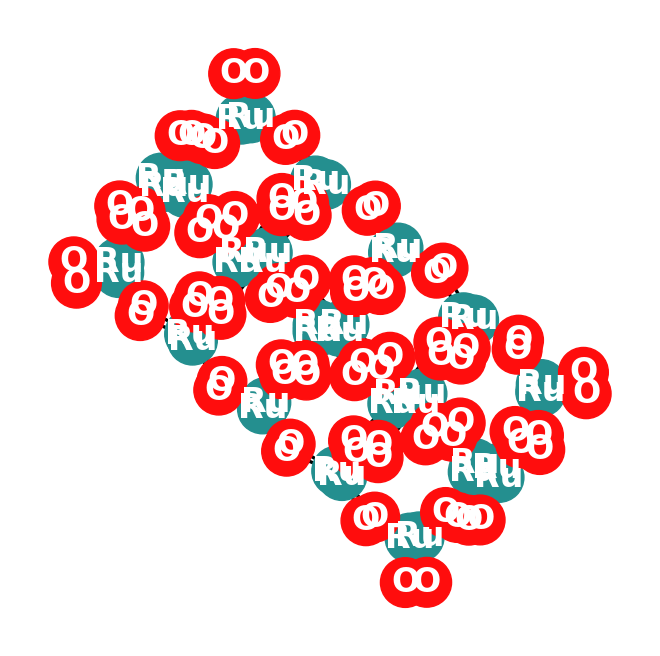

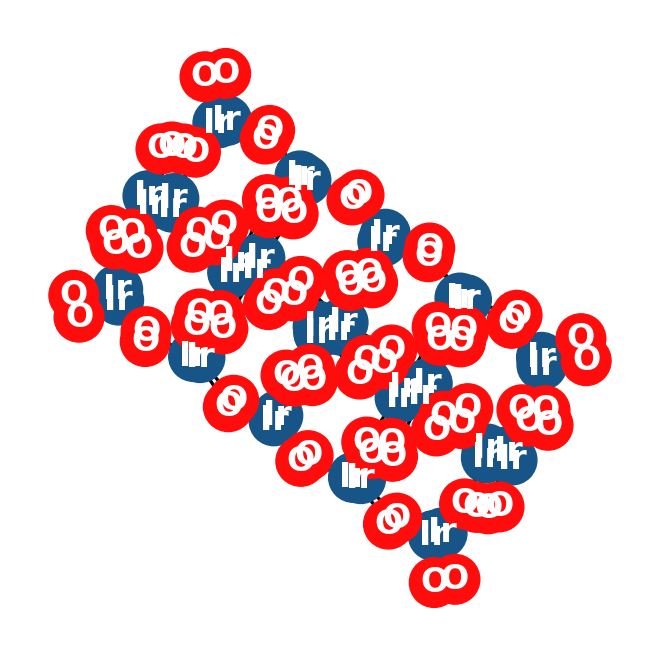

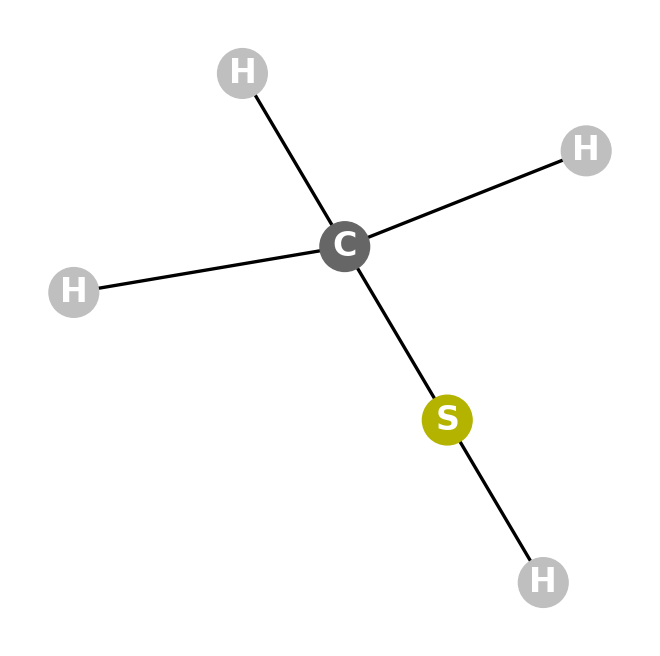

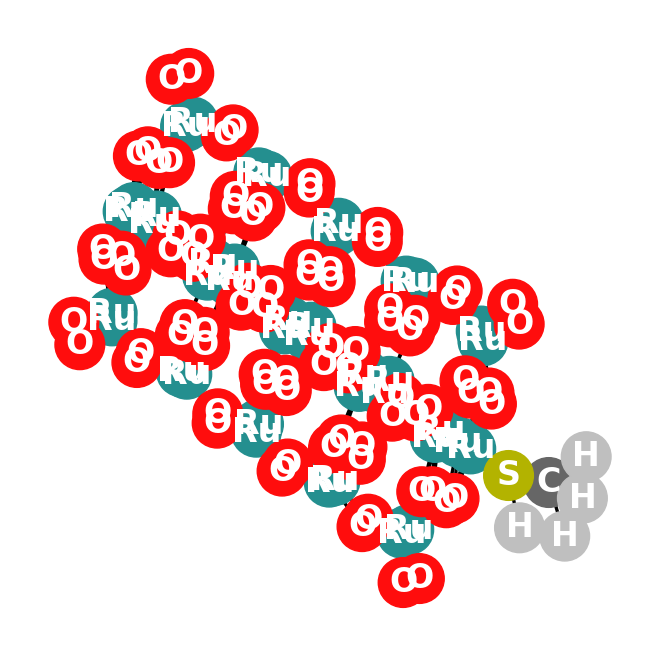

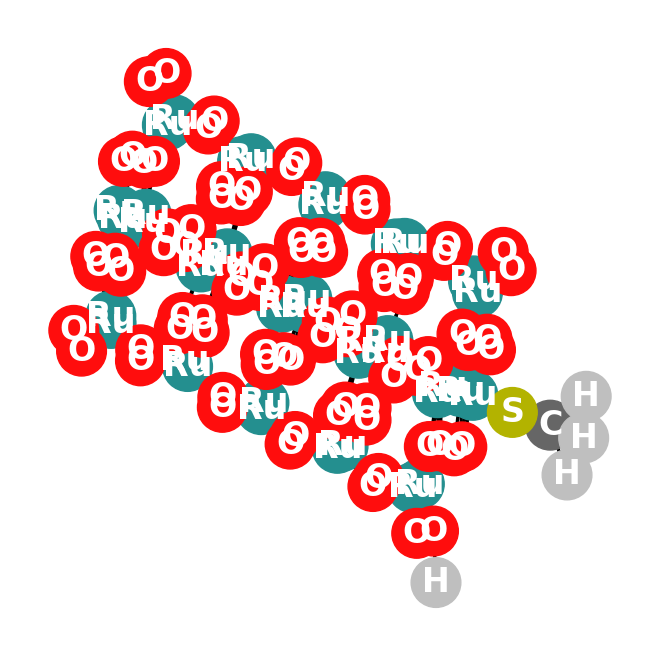

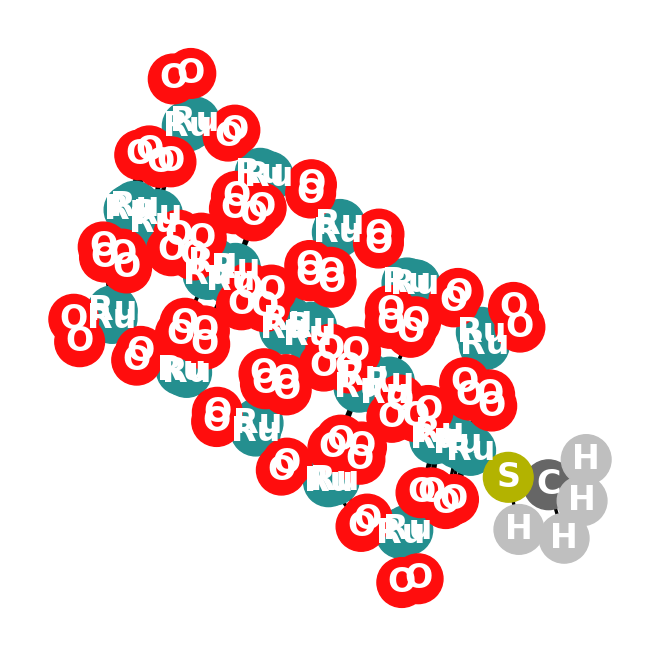

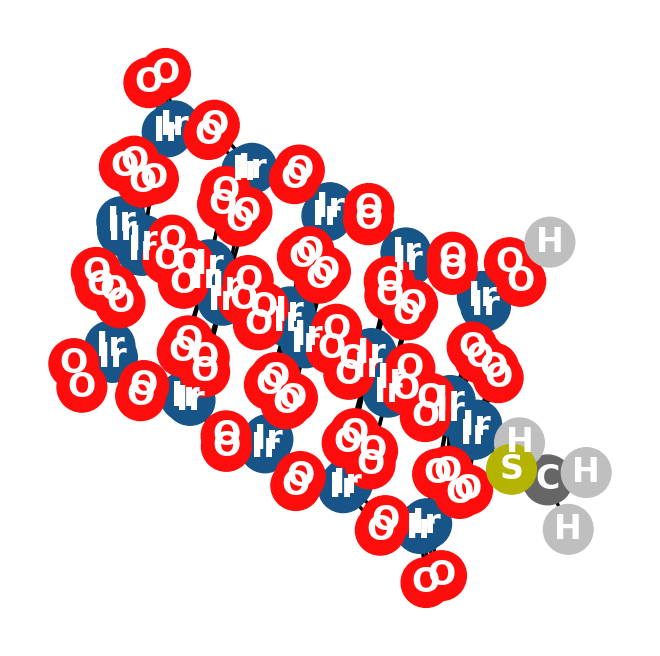

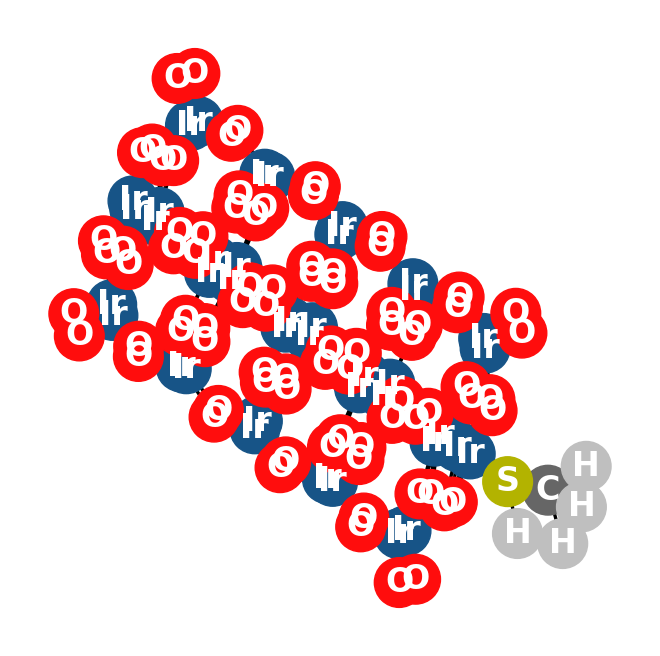

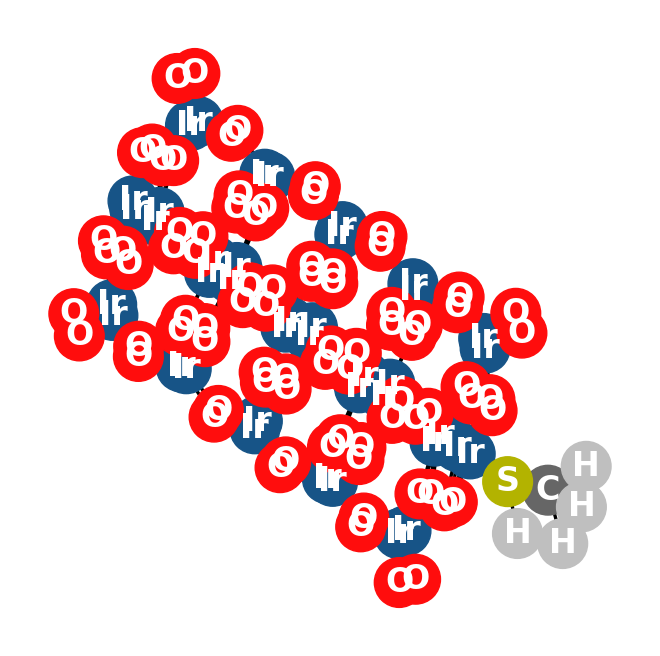

In [ ]:
for graph in dataset:
    graph_plotter(graph, node_index=False)